# FINM 250 - TA Review 2 - Linear Regression, Risk Measures
#### Tobias Rodriguez, 2025

## Risk Metrics

### Value at Risk (VaR) and Conditional Value at Risk (CVaR)

Value at Risk (VaR) is a measure of the maximum loss that a portfolio can suffer over a given time horizon at a given confidence level. It is a measure of downside risk. In this class, we just use the quantile of the returns distribution. So: VaR(0.05) is the 5% quantile of the returns distribution.

$$
\text{VaR}(q) = r_{i} \text{ such that } P(X \leq r_i) = q
$$

Conditional Value at Risk (CVaR) is a measure of the expected loss given that the loss is greater than the VaR. It is a measure of the expected downside risk. In this class, we just use the mean of the returns that are less than the VaR. So: CVaR(0.05) is the mean of the returns that are less than the 5% quantile of the returns distribution.

$$
\text{CVaR}(q) = \mathbb{E}[X | X < \text{VaR}(q)]
$$

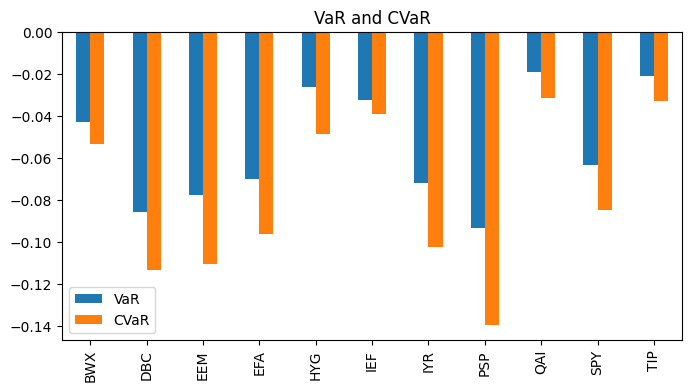

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

etfs = pd.read_excel(
    "../data/multi_asset_etf_data.xlsx",
    sheet_name="excess returns",
    index_col=0,
    parse_dates=[0],
)

var = etfs.quantile(0.05).to_frame("VaR")
var["CVaR"] = etfs[etfs < etfs.quantile(0.05)].mean()
var.plot(kind="bar", figsize=(8, 4), title="VaR and CVaR");

### Skewness and Kurtosis
Skewness is a measure of the asymmetry of a distribution. It is defined as:

$$
\frac{\mathbb{E}[X - \mu]^3}{\sigma^3}
$$

Kurtosis is a measure of the "tailedness" of a distribution. It is defined as:

$$
\frac{\mathbb{E}[X - \mu]^4}{\sigma^4}
$$


Note that:

- These are the third and fourth standardized moments of a distribution.
- The normal distribution has zero skewness and kurtosis of 3.
- Skewness measures the asymmetry of a distribution, and kurtosis measures the "tailedness" of a distribution.
- Importantly, pandas already measures excess kurtosis

Lets dive deeper by looking at SPY.

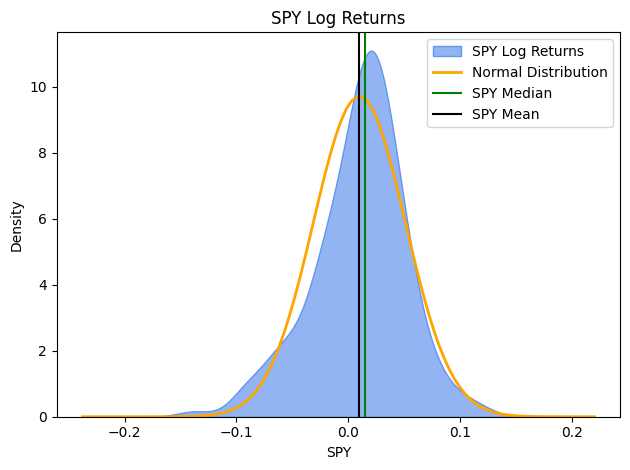

Skewness: -0.53
Kurtosis (Excess): 0.85


In [2]:
import scipy.stats as stats

# Convert SPY % returns to log returns
spy_log = np.log1p(etfs["SPY"])

# Plot the smoothed KDE of the log returns
sns.kdeplot(
    spy_log, shade=True, color="cornflowerblue", alpha=0.7, label="SPY Log Returns"
)

# Plot a log-normal distribution with the same mean and std as the log returns
x = np.linspace(spy_log.min() - 0.1, spy_log.max() + 0.1, 100)
# Fit a normal distribution to the log returns
mu, sigma = stats.norm.fit(spy_log)
y = stats.norm.pdf(x, mu, sigma)

plt.plot(x, y, color="orange", lw=2, label="Normal Distribution")
plt.axvline(spy_log.median(), c="g", label="SPY Median")
plt.axvline(spy_log.mean(), c="k", label="SPY Mean")


plt.legend()
plt.title("SPY Log Returns")
plt.tight_layout()
plt.show()
print(f"Skewness: {stats.skew(spy_log):.2f}")
print(f"Kurtosis (Excess): {stats.kurtosis(spy_log):.2f}")

Why might skewness and kurtosis matter when thinking about risk?

Note that the typical financial asset return will typically have negative skewness and positive kurtosis. Looking at the mean and median, we the median is high than the mean. So what this is telling us is that on the "average" day we make a small amount of money, but on bad days we lose a lot of money. This is consistent with the saying of "the bull walks up the stairs and the bear jumps out the window".

What about kurtosis? In thinking of the formula, there is a lot of weight in the tails (due to raising something to the fourth power). This tells us how big the tails are.

What is "reasonable" skewness and kurtosis?

In general, these risk measures are not super intuitive (eg. mean and vol are useful in isolation) when used on their own. However, they *are* useful when comparing different assets. For example, if you are comparing two assets are they are identical in every aspect except for kurtosis, then you might consider that one to be less risky than the other. Similarly, if two assets are the same except for skewness, an investor might prefer a less negatively skewed asset, as it has less risk of large losses.

Are there any assets with positive skewness?

### Market Beta, Information Ratio and Treyor Ratio

Market beta:

$$
r_i = \alpha_i + \beta_i r_m + \epsilon_i
$$

In this class, we only use the linear market beta, ie. the coefficient that we get when we regress the returns of the asset on the returns of the market. This is a measure of the systematic risk of the asset.

Arguably more useful is the downside beta:

$$
r_i = \alpha_i + \beta_i r_m + \epsilon_1, \;\;\;\; r_m < 0
$$

Which regresses the returns of the asset on the returns of the market, but only when the market is down. This is a measure of the systematic downside risk of the asset. Why might this be more useful in a hedge fund setting?

Information ratio:

$$
\text{IR} = \frac{\alpha}{\sigma(\epsilon)}
$$

We can kind of intuit what this measures. is the constant in the linear regression, so it measures the excess return of an asset. The standard deviation of measures how far off the linear line the asset is. So, a higher information ratio means that the asset has a consistently higher excess return, whereas a lower one either means negative excess return, or that the asset is very volatile.

In [3]:
# Regress PSP on SPY
regr_3 = sm.OLS(etfs["PSP"], sm.add_constant(etfs["SPY"])).fit()
regr_downside = sm.OLS(
    etfs["PSP"][etfs["SPY"] < 0], sm.add_constant(etfs["SPY"][etfs["SPY"] < 0])
).fit()

beta = regr_3.params["SPY"]
downside_beta = regr_downside.params["SPY"]
alpha = regr_3.params["const"]
information_ratio = (regr_3.params[0] / regr_3.resid.std()) * np.sqrt(12)

print(f"Beta: {beta:.2f}")
print(f"Downside Beta: {downside_beta:.2f}")
print(f"Alpha: {alpha:.4f}")
print(f"Information Ratio: {information_ratio:.2f}")

Beta: 1.33
Downside Beta: 1.50
Alpha: -0.0065
Information Ratio: -0.81


In [4]:
# As an example showing how information ratio can change.
spy = etfs["SPY"]

# Add tight gaussian noise + 0.001 to the returns.
asset_1 = spy + np.random.normal(0, 0.001, len(spy)) + 0.001
asset_2 = spy + np.random.normal(0, 0.2, len(spy)) + 0.1

# Regress and calculate information ratio.
regr_1 = sm.OLS(asset_1, sm.add_constant(spy)).fit()
regr_2 = sm.OLS(asset_2, sm.add_constant(spy)).fit()

ir_1 = (regr_1.params[0] / regr_1.resid.std()) * np.sqrt(12)
ir_2 = (regr_2.params[0] / regr_2.resid.std()) * np.sqrt(12)

# Calculate betas and downside betas
beta_1 = regr_1.params["SPY"]
beta_2 = regr_2.params["SPY"]
downside_beta_1 = (
    sm.OLS(asset_1[spy < 0], sm.add_constant(spy[spy < 0])).fit().params["SPY"]
)
downside_beta_2 = (
    sm.OLS(asset_2[spy < 0], sm.add_constant(spy[spy < 0])).fit().params["SPY"]
)

print(f"Beta 1: {beta_1:.2f}")
print(f"Beta 2: {beta_2:.2f}")

print(f"Downside Beta 1: {downside_beta_1:.2f}")
print(f"Downside Beta 2: {downside_beta_2:.2f}")

print(f"Information Ratio 1: {ir_1:.2f}")
print(f"Information Ratio 2: {ir_2:.2f}")

Beta 1: 1.00
Beta 2: 1.05
Downside Beta 1: 1.01
Downside Beta 2: 2.02
Information Ratio 1: 2.84
Information Ratio 2: 1.79


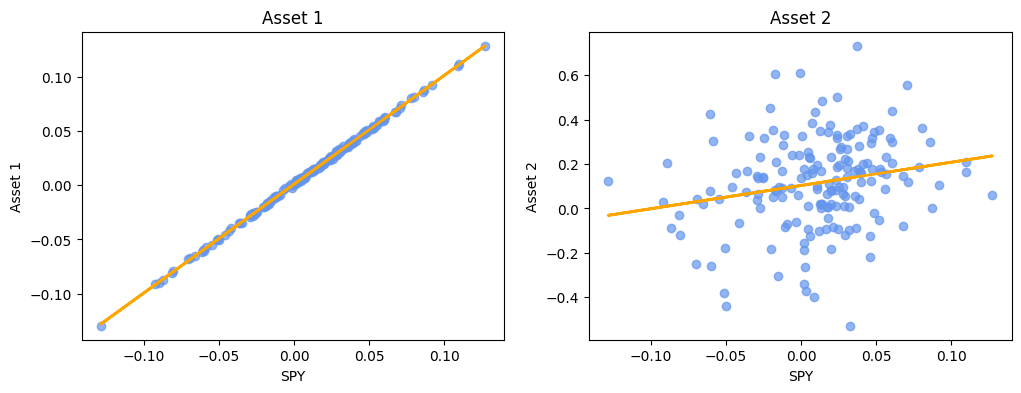

In [5]:
# And graphically
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(spy, asset_1, color="cornflowerblue", alpha=0.7)
axes[0].plot(spy, regr_1.predict(sm.add_constant(spy)), color="orange", lw=2)
axes[0].set_title("Asset 1")
axes[0].set_xlabel("SPY")
axes[0].set_ylabel("Asset 1")

axes[1].scatter(spy, asset_2, color="cornflowerblue", alpha=0.7)
axes[1].plot(spy, regr_2.predict(sm.add_constant(spy)), color="orange", lw=2)
axes[1].set_title("Asset 2")
axes[1].set_xlabel("SPY")
axes[1].set_ylabel("Asset 2");

Treynor ratio:

$$
\text{TR} = \frac{\bar{r}}{\beta}
$$

What is this measuring? Here, we're dividing our returns by the market beta of the asset. So, we are measuring the return per unit of market risk. When might this be useful? Consider 2 assets, SPY, and SPY with 2x leverage. Their Treynor ratios will be the same even though their betas are different! Or, consider 0.5x SPY (50% SPY, 50% cash), again, the Treynor ratio will be the same.

### Maximum Drawdown

This is normally one of the more counterintuitive risk metrics. It is defined as: the maximum percentage loss that you can expect to suffer over the given time horizon. So, if my portfolio goes something like:

10, 1, 100, 15

Then my maximum drawdown is 90%. Why? Because although going from 100 to 15 is a 85% loss, it is not the maximum loss that I can expect to suffer. I can expect to suffer a 90% loss, because I can go from 10 to 1.

## Linear Regression

Linear regression is the 🐐 statistical tool that lets us model the relationship between a dependent variable, $y$, and one or more independent variables, $\boldsymbol{X}$. I'm sure many of you have seen the concept of "line of best fit"; this is exactly what linear regression is doing.

$$\boldsymbol{y} = \boldsymbol{\beta} \boldsymbol{X} + \epsilon$$

Note that the **bold** font indicates matrices/vectors. In particular, the defining feature of a linear regression is that it is linear in the parameters $\boldsymbol{\beta}$ and $\boldsymbol{c}$, not necessarily the independent variables $\boldsymbol{X}$. That is, $\boldsymbol{X}$ could be:

- quantitative inputs
- transforms of quantitative inputs (log, square-root, cosine, etc.)
- basis expansions (polynomials, splines, etc.)
- categorical inputs (one-hot encoding, etc.)
- interactions of the above

Thus, although the model is linear in the parameters, it can be highly non-linear in the inputs. This is part of the reason why linear regression is so powerful. An OLS (ordinary least squares) linear regression model is one that minimizes the sum of squared residuals:

$$
\hat{\beta} = \arg \min_\beta \sum_{i=1}^{N}\left(y_i - \beta_0 - \sum_{j=1}^{p}x_{i,j}\beta_j\right)^2
$$

You will also see closed-form solutions for OLS:

$$
\hat{\boldsymbol{\beta}} = \left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}
$$

We need some assumptions to hold for OLS to work:

- **Linearity**: the relationship between the dependent variable and the independent variables is linear in the parameters.
- **Independence**: the residuals are independent of each other.
- **Normality**: the residuals are normally distributed ($\epsilon \sim N(0, \sigma)$).
- **Homoscedasticity**: the variance of the residuals is constant (also called the "no heteroskedasticity" assumption).
- **No multicollinearity/autocorrelation**: the independent variables are not too highly correlated with each other in space or time.

There are many resources to learn more about linear regression. I recommend the following:

- Elements of Statistical Learning: [Chapter 3](https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf)
- Pattern Recognition and Machine Learning: [Chapter 3](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
- [Wikipedia](https://en.wikipedia.org/wiki/Linear_regression)
- [Statsmodels](https://www.statsmodels.org/stable/regression.html)
- [Scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html)
- [Video](https://www.youtube.com/watch?v=EMIyRmrPWJQ)
- [Video](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
- Most articles or videos that you can find online are good.
- A more "advanced" version of this review [here](https://github.com/MarkHendricks/finm-portfolio-2023/blob/main/review/Portfolio%202023%20-%20TA%20Review%20Session%202.ipynb).

Note that this covers a wide span of difficulties; this review alone mostly suffices for this class. The other resources are for those who want to learn more.

### 1.1. Linearity

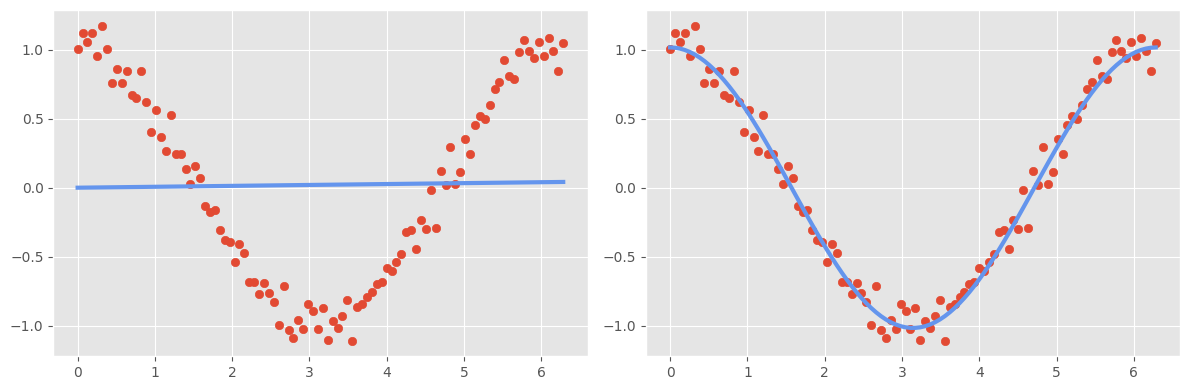

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../cmds/")
from utils import *

# Set ggplot theme
plt.style.use("ggplot")

x = np.linspace(0, 2 * np.pi, 100)
y = np.cos(x) + np.random.normal(0, 0.1, 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(x, y)

model = sm.OLS(y, x).fit()
y_hat = model.predict(x)
axes[0].plot(x, y_hat, c="cornflowerblue", lw=3)

x_cos = np.cos(x)
axes[1].scatter(x, y)
model_cos = sm.OLS(y, x_cos).fit()
y_hat_cos = model_cos.predict(x_cos)
axes[1].plot(x, y_hat_cos, c="cornflowerblue", lw=3)
fig.tight_layout()

### Independence, Normality, Homoscedasticity

We skip these, as they are beyond the scope of this class. Feel free to ask me about them during office hours or on Canvas! This section mainly pertains to analyzing the $\epsilon$ term.

### Applying Linear Regression

For starters, why does linear regression come naturally in finance? For starters, think about what a portfolio is: a *linear* combination of assets! Even if a given asset payoff is not linear (eg. a call option), the portfolio payoff is linear in the weights.

Note that replication and hedging are two sides of the same coin.

To that end, lets run through a hedging example. Suppose we want to hedge PSP with SPY. We can do this by regressing the returns of PSP on the returns of SPY, and then using the coefficients to hedge PSP.

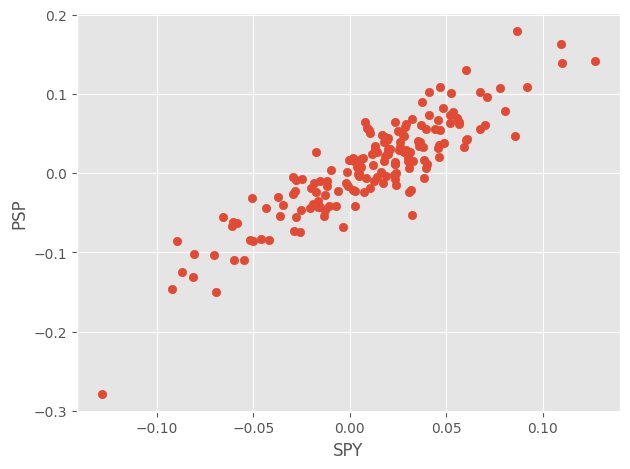

In [7]:
# Step 1, plot the data.
psp = etfs["PSP"]
spy = etfs["SPY"]

fig, ax = plt.subplots()
ax.scatter(x=spy, y=psp)
ax.set_xlabel("SPY")
ax.set_ylabel("PSP")
fig.tight_layout()

In [8]:
# Step 2, fit our linear regression mode
model = sm.OLS(psp, sm.add_constant(spy), missing="drop").fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PSP   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     659.7
Date:                Sat, 12 Jul 2025   Prob (F-statistic):           2.07e-60
Time:                        15:56:33   Log-Likelihood:                 372.17
No. Observations:                 172   AIC:                            -740.3
Df Residuals:                     170   BIC:                            -734.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0065      0.002     -2.955      0.004      -0.011      -0.002
SPY            1.3320      0.052     25.685      0.000       1.230       1.434
==============================================================================
Omnibus:                        6.278   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                6.585
Skew:                          -0.320   Prob(JB):                       0.0372
Kurtosis:                       3.713   Cond. No.                         24.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

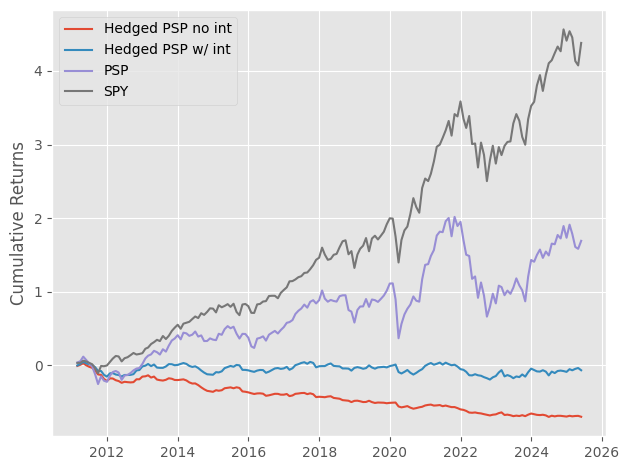

In [9]:
# So our hedged returns are now...
r_hedge = psp - model.params["SPY"] * spy
r_hedge_int = psp - model.predict(sm.add_constant(spy))
plt.figure()
plt.plot((1 + r_hedge).cumprod() - 1, label="Hedged PSP no int")
plt.plot((1 + r_hedge_int).cumprod() - 1, label="Hedged PSP w/ int")
plt.plot((1 + psp).cumprod() - 1, label="PSP")
plt.plot((1 + spy).cumprod() - 1, label="SPY")
plt.legend()
plt.ylabel("Cumulative Returns")
plt.tight_layout()

What might be the issue with including a constant for replication purposes? What about hedging?

$$
r_{j} = \alpha_i + \beta_i r_{i} + \epsilon_i
$$

What is $\mathbb{E}[\epsilon]$?

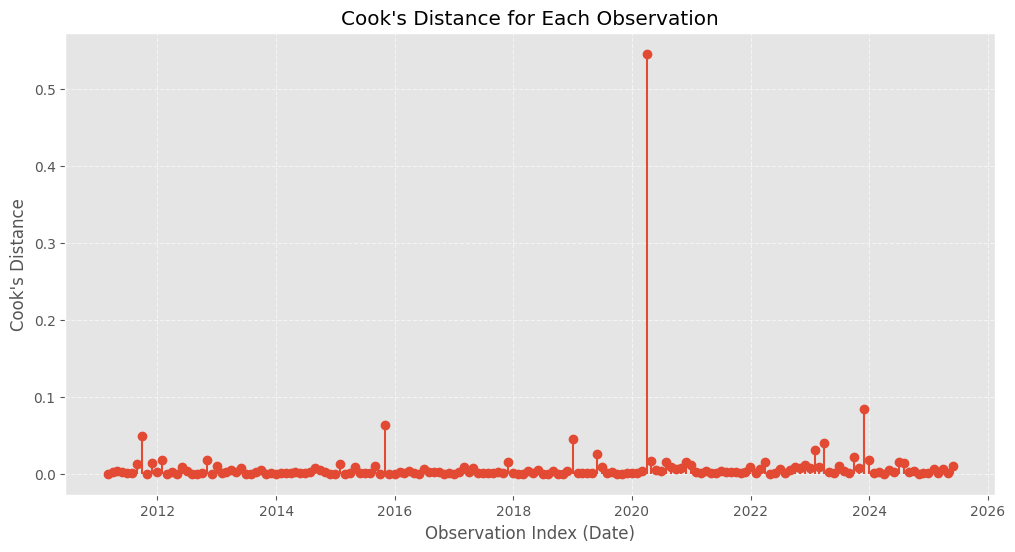

In [10]:
influence = model.get_influence()
cooks_distance = influence.cooks_distance[0]

# Create a DataFrame for easier plotting and analysis
cooks_df = pd.DataFrame({"Cooks_D": cooks_distance}, index=psp.index)

plt.figure(figsize=(12, 6))
plt.stem(cooks_df.index, cooks_df["Cooks_D"], markerfmt="o", basefmt=" ")
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index (Date)")
plt.ylabel("Cook's Distance")
plt.grid(True, linestyle="--", alpha=0.6)

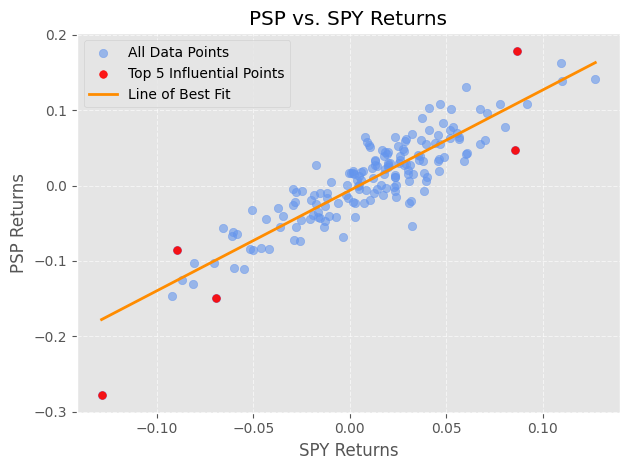

In [11]:
top_n = 5
most_influential_indices = cooks_df.nlargest(top_n, "Cooks_D").index

fig, ax = plt.subplots()
ax.scatter(x=spy, y=psp, color="cornflowerblue", alpha=0.6, label="All Data Points")
ax.scatter(
    x=spy.loc[most_influential_indices],
    y=psp.loc[most_influential_indices],
    color="red",
    s=30,
    alpha=0.9,
    zorder=2,
    label=f"Top {top_n} Influential Points",
)

x_range = np.linspace(spy.min(), spy.max(), 100)
y_pred = model.params["const"] + model.params["SPY"] * x_range
ax.plot(x_range, y_pred, color="darkorange", linewidth=2, label="Line of Best Fit")


ax.set_xlabel("SPY Returns")
ax.set_ylabel("PSP Returns")
ax.set_title("PSP vs. SPY Returns")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.6)
fig.tight_layout()
plt.show()

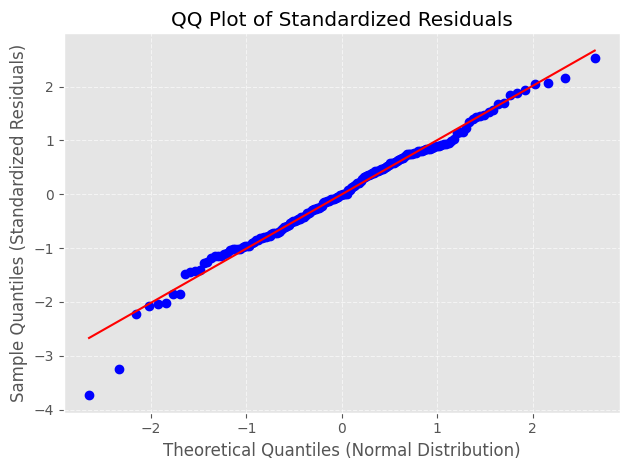

In [12]:
standardized_residuals = model.get_influence().resid_studentized_internal

plt.figure()
stats.probplot(standardized_residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Standardized Residuals")
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Sample Quantiles (Standardized Residuals)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()